Imports necessários para fazer os testes

In [1]:
import A_construct as c
import A_detect as d
import A_transform as t

import cv2
import os
import numpy.random as random
import numpy as np
import matplotlib.pyplot as plt
import math

from __future__ import print_function
from imutils import perspective
from imutils import contours
import numpy as np
import cv2
from scipy.spatial import distance as dist
import matplotlib.pyplot as plt
import statistics


import csv


In [2]:
#funções de display
def display_images(images):
    num_images = len(images)
    fig, ax = plt.subplots(1, num_images, figsize=(10, 5))
    for i in range(num_images):
        ax[i].imshow(images[i],cmap='gray')
        ax[i].set_title(f'Image {i+1}')
        ax[i].set_axis_off()
    plt.show()

def draw_circles(green_circles, output):
    image=output.copy()
    for circle in green_circles:
        x, y, r = circle
        image = cv2.circle(image, (x, y), r, (0, 255, 0), 4)
        image = cv2.rectangle(image, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)
    return image


def apply_canny_edge_detection(image, low_threshold, high_threshold):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Step 1: Apply Gaussian blur
    blurred = cv2.GaussianBlur(gray, (21, 21), 0)

    # Step 2: Apply Canny edge detection
    edges = cv2.Canny(blurred, threshold1=low_threshold,threshold2=high_threshold,apertureSize=5)

    # Step 3: Apply non-maximum suppression
    dx = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=3)
    dy = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(dx ** 2 + dy ** 2)
    gradient_direction = np.arctan2(dy, dx) * (180 / np.pi)
    gradient_direction = (gradient_direction + 180) % 180
    suppressed = np.zeros_like(edges)
    rows, cols = edges.shape
    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            direction = gradient_direction[i, j]
            if (0 <= direction < 22.5) or (157.5 <= direction <= 180):
                if (gradient_magnitude[i, j] >= gradient_magnitude[i, j + 1]) and (
                        gradient_magnitude[i, j] >= gradient_magnitude[i, j - 1]):
                    suppressed[i, j] = gradient_magnitude[i, j]
            elif (22.5 <= direction < 67.5):
                if (gradient_magnitude[i, j] >= gradient_magnitude[i + 1, j + 1]) and (
                        gradient_magnitude[i, j] >= gradient_magnitude[i - 1, j - 1]):
                    suppressed[i, j] = gradient_magnitude[i, j]
            elif (67.5 <= direction < 112.5):
                if (gradient_magnitude[i, j] >= gradient_magnitude[i + 1, j]) and (
                        gradient_magnitude[i, j] >= gradient_magnitude[i - 1, j]):
                    suppressed[i, j] = gradient_magnitude[i, j]
            elif (112.5 <= direction < 157.5):
                if (gradient_magnitude[i, j] >= gradient_magnitude[i + 1, j - 1]) and (
                        gradient_magnitude[i, j] >= gradient_magnitude[i - 1, j + 1]):
                    suppressed[i, j] = gradient_magnitude[i, j]

    # Step 4: Apply hysteresis thresholding
    thresholded= cv2.Canny(blurred, threshold1=low_threshold,threshold2=high_threshold,apertureSize=5)

    sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 1, ksize=5)
    sobel = cv2.convertScaleAbs(sobel)

    # Create a new image by horizontally concatenating the processed images
    #output = np.hstack((gray,blurred, sobel, suppressed, thresholded))
    output=thresholded
    return output



def detect_circles_final(img_color,img_canny,tolerancia,tolerancia_int,minR, maxR):
    sum_int=int((maxR-minR)/4)
    one=minR
    two=55
    tree=85
    four=maxR

    first=d.detect_circles_color(img_color,img_canny,tolerancia=80,tolerancia_int=1,dp=1.5,center_dist=10,param2=10,minR=one-10,maxR=two)
    second=d.detect_circles_color(img_color,img_canny,tolerancia=50,tolerancia_int=1,dp=1.5,center_dist=10,param2=30,minR=two,maxR=tree)
    third=d.detect_circles_color(img_color,img_canny,tolerancia=20,tolerancia_int=1,dp=1.5,center_dist=10,param2=60,minR=tree,maxR=four)
    small=first[3]
    small_image=first[0]
  
    medium=second[3]
    medium_image=second[0]
    big=third[3]
    big_image=third[0]

    inicial=d.remove_repeated_circles_mod(small,medium,tolerance=1)
    final=d.remove_repeated_circles_mod(big,inicial,tolerance=1)
    
    return[final,small_image,medium_image,big_image]


def detect_circles_score(img_color, original_circles, detected_circles, tolerance=1, radius_margin=1):
    # Extract the centers and radii from the detected circles
    # Convert the expected circles to NumPy arrays, converting string values to integers
    original_centers = np.array(original_circles, dtype=int)[:, :2]
    original_radii = np.array(original_circles, dtype=int)[:, 2]
    
    
    detected_circles = np.array(detected_circles)
    detected_centers = detected_circles[:, :2]
    detected_radii = detected_circles[:, 2]
    number_of_P=len(detected_radii)

    print('detetados',len(detected_radii))
    #print('média detetados', statistics.mean(detected_radii))
    #print(detected_radii)
    #print('detetados/numero de colocados', sum(detected_radii)/len(original_radii))
    #print(original_radii)
    #print('colocados', statistics.mean(original_radii))
    # Initialize arrays to store which circles were correctly detected
    placed_circles = np.zeros(len(original_centers))
    total_number_of_circles=len(placed_circles)

    flag=0
    img=img_color.copy()
    

    # Check if each original circle has a corresponding detected circle within the given tolerance
    for i, (oc, orad) in enumerate(zip(original_centers, original_radii)):
        distances = np.linalg.norm(detected_centers - np.array(oc), axis=1)
        #print(distances)
        if list(distances)==[]:
            #print('Hello?')
            break

        matches = np.argmin(distances)
        #if distances[matches]>10:
            #img=cv2.line(imagem,oc,detected_centers[matches], (255,0,0), 9)
        if distances[matches]<= tolerance*orad:

            flag=flag+1

            # If there is a match, check if the radii match within the given margin
            detected_radius = detected_radii[matches]
            if abs((orad-detected_radius))<=radius_margin*orad:
                # If the radii match within the margin, mark the original circle and detected circle as correct
                placed_circles[i] = 1

                # Remove the detected circle so it can't be matched to another original circle
                detected_centers = np.delete(detected_centers, matches, axis=0)
                detected_radii = np.delete(detected_radii, matches)
            else:
                
                img=cv2.circle(img, oc, int(orad), (255, 0, 0), 2)
        else:
            
            img=cv2.circle(img, oc, int(orad), (255, 0, 0), 2)

    for f in range(len(detected_radii)):
        det_rad = detected_radii[f]
        det_center = detected_centers[f]
        img = cv2.circle(img, tuple(det_center), int(det_rad), (0, 0, 255), 2)

    number_of_FP=len(detected_radii)
    # Calculate the percentage of correct detections
    number_of_TP=np.sum(placed_circles)
    number_of_FN=total_number_of_circles-number_of_P
    #print('numero de Fn',number_of_FN)
    #print('number of p',number_of_P)
    #print('number of tp', number_of_TP)

    recall = number_of_TP / total_number_of_circles * 100

    #number_of_FP= number_of_P - number_of_TP

    precision=number_of_TP/number_of_P*100
    #print('recall',recall)
    #print('precision',precision)

    return [recall,img,precision]

In [3]:
import pandas as pd
import glob

# Specify the directory where your CSV files are located
directory = r"C:\Users\Asus\Desktop\final videos coluna\final\c1_1"

# Get a list of all CSV files in the directory
csv_files = glob.glob(directory + '\\*.csv')

# Initialize an empty list to store the data from each CSV
data = []

# Loop through each CSV file
for file in csv_files:
    # Read the CSV file and append its data to the list
    df = pd.read_csv(file)
    data.append(df)

# Concatenate all the data into a single DataFrame
concatenated_data = pd.concat(data, ignore_index=True)

# Save the concatenated data to a new CSV file
concatenated_data.to_csv( r"C:\Users\Asus\Desktop\final videos coluna\final\comparação de distribuições\anotados_c1_1.csv", index=False)



In [4]:
def process_csv_and_images(folder_path):
    # Get a list of all the CSV files in the folder
    csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]
    anotados = []
    encontrados = []
    recall_list = []
    precision_list = []
    Vol_anotados = []
    Vol_encontrados = []
    circ_encon=[]

    for csv_file in csv_files:
        # Find the corresponding image file with the same name as the CSV file (but ending with '.jpg')
        csv_file_name = os.path.splitext(csv_file)[0]
        image_file_name = csv_file_name + '.jpg'
        image_file_path = os.path.join(folder_path, image_file_name)
        im_right = cv2.imread(image_file_name)
        # Resize the image
        desired_width = 1000
        desired_height = 2000
        im_right = cv2.resize(im_right, (desired_width, desired_height))

        # Apply Canny edge detection with the specified thresholds
        low_threshold = 50
        high_threshold = 110
        result = apply_canny_edge_detection(im_right, low_threshold, high_threshold)
        result=t.apply_morphology_operations(result)

        #circle detection
        resultado=detect_circles_final(im_right,result,tolerancia=10,tolerancia_int=1,minR=35,maxR=150)
        circulos_encontrados=resultado[0]
        circ_encon.append(circulos_encontrados)
        raios_encontrados = [int(circle[2]) for circle in circulos_encontrados]

        #imagem_final_2=d.draw_green_circles(lista_2,im_right)

        #csv open and analise
        file_right = open (csv_file)
        csvreader = csv.reader(file_right)
        circulos_anotados = []
        for row in csvreader:
            circulos_anotados.append(row)
        #print(rows)
        file_right.close()
        raios_anotados = [int(circle[2]) for circle in circulos_anotados]

        Valor=detect_circles_score(im_right,circulos_anotados,circulos_encontrados,tolerance=0.5,radius_margin=0.5)

        anotados.append(raios_anotados)
        encontrados.append(raios_encontrados)
        recall_list.append(Valor[0])
        precision_list.append(Valor[2])

        v_anotadas = [(4/3) * math.pi * (radius ** 3) for radius in raios_anotados]
        Vol_anotados.append(sum(v_anotadas))

        v_encontrados = [(4/3) * math.pi * (radius ** 3) for radius in raios_encontrados]
        Vol_encontrados.append(sum(v_encontrados))

    anotados = [radius for sublist in anotados for radius in sublist]
    encontrados = [radius for sublist in encontrados for radius in sublist]
    circ_encon=[radius for sublist in circ_encon for radius in sublist]

    return anotados, encontrados, recall_list, precision_list, Vol_anotados, Vol_encontrados,circ_encon



caminho_da_pasta=r"C:\Users\Asus\Desktop\final videos coluna\final\c1_1"

stat=process_csv_and_images(caminho_da_pasta)

print(stat)

detetados 26
detetados 32
detetados 26
detetados 38
detetados 36
detetados 31
detetados 33
detetados 26
detetados 41
detetados 33
detetados 23
detetados 23
detetados 24
detetados 33
detetados 32
detetados 35
detetados 36
detetados 28
detetados 37
detetados 34
detetados 28
detetados 33
detetados 29
detetados 26
detetados 25
detetados 27
detetados 30
detetados 33
detetados 33
detetados 32
detetados 28
detetados 32
detetados 32
detetados 30
detetados 32
detetados 39
detetados 30
detetados 24
([81, 93, 87, 53, 72, 52, 41, 58, 32, 34, 34, 80, 47, 70, 50, 25, 54, 59, 38, 47, 36, 29, 90, 39, 71, 47, 18, 27, 44, 62, 74, 70, 65, 57, 88, 67, 70, 59, 43, 39, 46, 36, 44, 59, 73, 42, 69, 76, 39, 48, 72, 68, 61, 50, 65, 40, 34, 29, 44, 45, 40, 108, 79, 62, 53, 62, 37, 71, 41, 109, 32, 42, 89, 71, 33, 55, 34, 59, 68, 52, 52, 51, 72, 80, 46, 66, 123, 41, 50, 85, 67, 76, 80, 78, 73, 38, 33, 39, 57, 60, 65, 60, 46, 52, 100, 53, 50, 44, 54, 40, 48, 46, 74, 93, 49, 43, 40, 25, 46, 41, 49, 35, 32, 51, 30, 

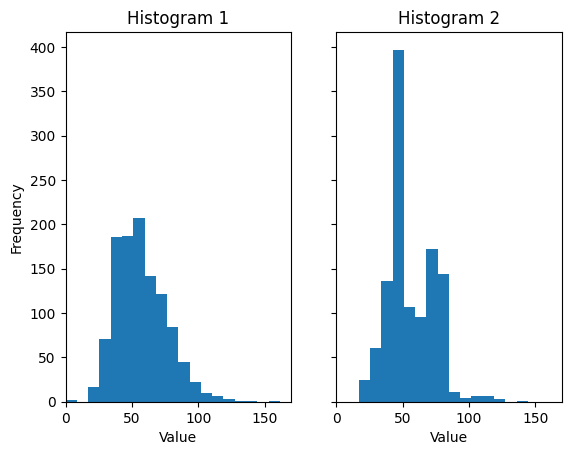

Sauter mean diameter for anotated: 76.58861681430734
Sauter mean diameter for found: 71.859788452373
A media dos diametros dos anotados é 56.903342366757
A media dos diametros dos encontrados é 55.835042735042734
A percentagem dos colocados encontrados é (Recall): 53.17686296199179
Precision: 50.3840785523332
Volume dos anotados 30685803.64804284
Volume dos encontrados 29276673.128045075


In [5]:
anotados, encontrados, recall_list, precision_list, Vol_anotados, Vol_encontrados,circ_encon=stat


import csv
def save_to_csv(anotados, file_path):
    # Open the CSV file in write mode
    with open(file_path, 'w', newline='') as csvfile:
        # Create a CSV writer object
        csv_writer = csv.writer(csvfile)

        # Write each radius as a separate row in the CSV file
        for radius in anotados:
            csv_writer.writerow([radius])

# Example usage

file_path = r"C:\Users\Asus\Desktop\final videos coluna\final\comparação de distribuições\encontrados_c1_1.csv"
save_to_csv(circ_encon, file_path)



bins = 20
x_range = (0, 170)

# Create the subplots
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

# Plot the first histogram
ax1.hist(anotados, bins=bins, range=x_range)
ax1.set_xlabel('Value')
ax1.set_ylabel('Frequency')
ax1.set_title('Histogram 1')

# Plot the second histogram
ax2.hist(encontrados, bins=bins, range=x_range)
ax2.set_xlabel('Value')
ax2.set_title('Histogram 2')

# Set the x-axis range for both subplots
ax1.set_xlim(x_range)
ax2.set_xlim(x_range)

# Display the figure
plt.show()

import statistics

# List of radii for colocados


# Calculate the total volume of colocados spheres
anotados_total_volume = sum([(4/3) * 3.14159 * radius**3 for radius in anotados])

# Calculate the volume fraction of each colocados sphere
anotados_volume_fractions = [(4/3) * 3.14159 * radius**3 / anotados_total_volume for radius in anotados]

# Calculate the Sauter mean diameter for colocados
anotados_sauter_mean_diameter = (sum([(radius * vf) for radius, vf in zip(anotados, anotados_volume_fractions)])) / sum(anotados_volume_fractions)

# Calculate the total volume of verdes spheres
encontrados_total_volume = sum([(4/3) * 3.14159 * radius**3 for radius in encontrados])

# Calculate the volume fraction of each verdes sphere
encontrados_volume_fractions = [(4/3) * 3.14159 * radius**3 / encontrados_total_volume for radius in encontrados]

# Calculate the Sauter mean diameter for verdes
encontrados_sauter_mean_diameter = (sum([(radius * vf) for radius, vf in zip(encontrados, encontrados_volume_fractions)])) / sum(encontrados_volume_fractions)

print("Sauter mean diameter for anotated:", anotados_sauter_mean_diameter)
print("Sauter mean diameter for found:", encontrados_sauter_mean_diameter)

# Calculate and print the statistics
print('A media dos diametros dos anotados é',statistics.mean(anotados))
print('A media dos diametros dos encontrados é',statistics.mean(encontrados))
print('A percentagem dos colocados encontrados é (Recall):', statistics.mean(recall_list))
print('Precision:', statistics.mean(precision_list))

V_med_anotados=statistics.mean(Vol_anotados)
V_med_encontrados=statistics.mean(Vol_encontrados)

print('Volume dos anotados',V_med_anotados)
print('Volume dos encontrados',V_med_encontrados)

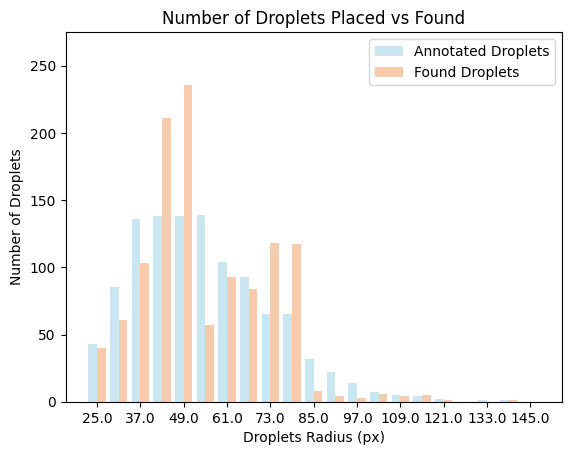

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Define the diam_max and diam_min values
diam_max = 300
diam_min = 70

# Calculate the maximum and minimum radii
maxR = diam_max / 2
minR = (diam_min / 2)-10

# Calculate the sum and create the bins
sum_bins = int((maxR - minR) / 20)
bins = np.arange(minR, maxR + sum_bins, sum_bins)

# Compute the histograms
col = np.histogram(anotados, bins=bins)[0]
ver = np.histogram(encontrados, bins=bins)[0]

X = [f'{bins[i]}' for i in range(len(bins)-1)] 

X_axis = np.arange(len(X))

col_color = (201/255, 230/255, 241/255)  # RGB tuple for a bluish color
ver_color = (248/255, 203/255, 173/255)  # RGB tuple for a reddish color

plt.bar(X_axis - 0.2, col, 0.4, label='Annotated Droplets', color=col_color)
plt.bar(X_axis + 0.2, ver, 0.4, label='Found Droplets', color=ver_color)

plt.xticks(X_axis[::2], X[::2]) 
plt.xlabel("Droplets Radius (px)")
plt.ylabel("Number of Droplets")
plt.title("Number of Droplets Placed vs Found")
# Set the y-axis limits to be between 0 and 300
plt.ylim(0, 275)

plt.legend()
plt.show()

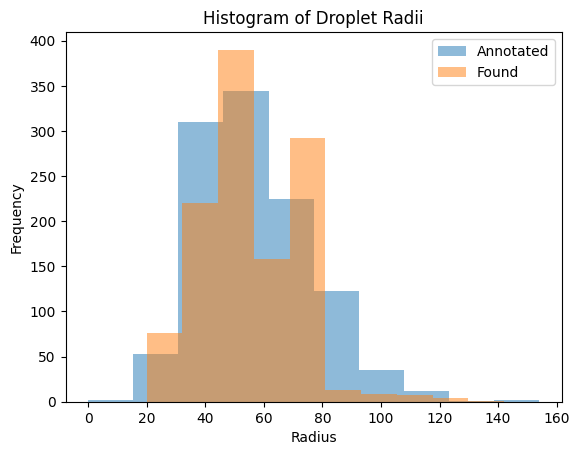

In [7]:
import matplotlib.pyplot as plt

# Assuming you have circle_list_ensaio1 and circle_list_ensaio2 defined

# Plotting the histograms
plt.hist(anotados, bins=10, alpha=0.5, label='Annotated')
plt.hist(encontrados, bins=10, alpha=0.5, label='Found')

plt.xlabel('Radius')
plt.ylabel('Frequency')
plt.title('Histogram of Droplet Radii')
plt.legend()

# Display the histogram
plt.show()


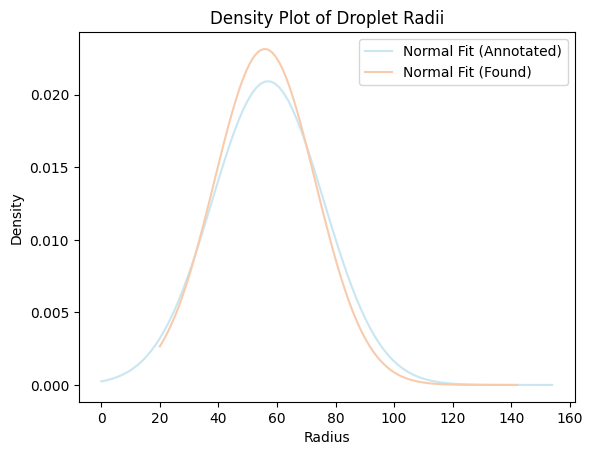

Estimated parameters for Camera 1:
μ (mu): 56.903342366757
σ (sigma): 19.05847649517906

Estimated parameters for Camera 2:
μ (mu): 55.835042735042734
σ (sigma): 17.22964954050929


In [8]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

mu_c1, sigma_c1 = norm.fit(anotados)

# Fit normal distribution to the data for Camera 2
mu_c2, sigma_c2 = norm.fit(encontrados)

# Generate the x-axis values for the probability density functions (pdf)
x_c1 = np.linspace(min(anotados), max(anotados), 100)
x_c2 = np.linspace(min(encontrados), max(encontrados), 100)

# Compute the corresponding probability density functions (pdf)
pdf_c1 = norm.pdf(x_c1, mu_c1, sigma_c1)
pdf_c2 = norm.pdf(x_c2, mu_c2, sigma_c2)


col_color = (201/255, 230/255, 241/255)  # RGB tuple for a bluish color
ver_color = (248/255, 203/255, 173/255)  # RGB tuple for a reddish color

# Plotting the normal curves
plt.plot(x_c1, pdf_c1, color=col_color, label='Normal Fit (Annotated)')
plt.plot(x_c2, pdf_c2, color=ver_color, label='Normal Fit (Found)')

plt.xlabel('Radius')
plt.ylabel('Density')
plt.title('Density Plot of Droplet Radii')

plt.legend()

# Display the plot
plt.show()

# Print the estimated μ (mu) and σ (sigma) parameters
print("Estimated parameters for Camera 1:")
print("μ (mu):", mu_c1)
print("σ (sigma):", sigma_c1)

print("\nEstimated parameters for Camera 2:")
print("μ (mu):", mu_c2)
print("σ (sigma):", sigma_c2)

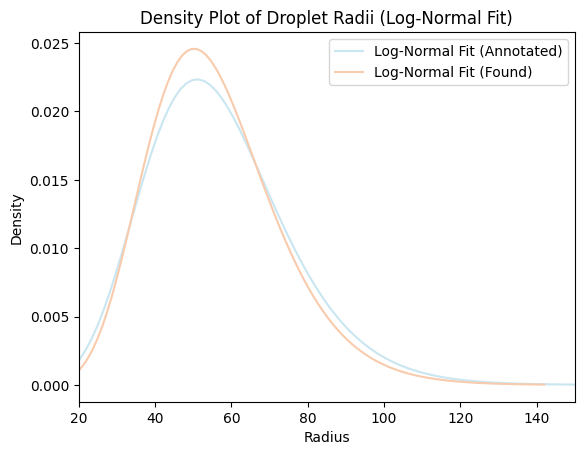

Estimated parameters for Log-Normal Fit (Annotated):
Shape: 0.21786552350241997
Location: -28.998844442637115
Scale: 83.88083798513108

Estimated parameters for Log-Normal Fit (Found):
Shape: 0.22813203224143414
Location: -19.0639564655363
Scale: 72.97904668857782


In [9]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import lognorm

# Fit log-normal distribution to the data for Camera 1
shape_c1, loc_c1, scale_c1 = lognorm.fit(anotados)

# Fit log-normal distribution to the data for Camera 2
shape_c2, loc_c2, scale_c2 = lognorm.fit(encontrados)

# Generate the x-axis values for the probability density functions (pdf)
x_c1 = np.linspace(min(anotados), max(anotados), 100)
x_c2 = np.linspace(min(encontrados), max(encontrados), 100)

# Compute the corresponding probability density functions (pdf)
pdf_c1 = lognorm.pdf(x_c1, shape_c1, loc=loc_c1, scale=scale_c1)
pdf_c2 = lognorm.pdf(x_c2, shape_c2, loc=loc_c2, scale=scale_c2)

col_color = (201/255, 230/255, 241/255)  # RGB tuple for a bluish color
ver_color = (248/255, 203/255, 173/255)  # RGB tuple for a reddish color

# Plotting the log-normal curves
plt.plot(x_c1, pdf_c1, color=col_color, label='Log-Normal Fit (Annotated)')
plt.plot(x_c2, pdf_c2, color=ver_color, label='Log-Normal Fit (Found)')

plt.xlabel('Radius')
plt.ylabel('Density')
plt.title('Density Plot of Droplet Radii (Log-Normal Fit)')

plt.xlim(20, 150)

plt.legend()

# Display the plot
plt.show()

# Print the estimated shape, location, and scale parameters for the log-normal distribution
print("Estimated parameters for Log-Normal Fit (Annotated):")
print("Shape:", shape_c1)
print("Location:", loc_c1)
print("Scale:", scale_c1)

print("\nEstimated parameters for Log-Normal Fit (Found):")
print("Shape:", shape_c2)
print("Location:", loc_c2)
print("Scale:", scale_c2)

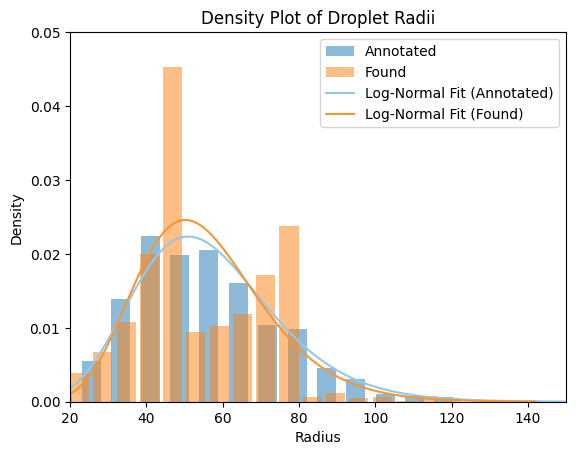


Estimated parameters for Log-Normal Fit (Annotated):
Shape: 0.21786552350241997
Loc: -28.998844442637115
Scale: 83.88083798513108

Estimated parameters for Log-Normal Fit (Found):
Shape: 0.22813203224143414
Loc: -19.0639564655363
Scale: 72.97904668857782


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import lognorm
# Assuming you have the data for all_radii and all_radii_2
all_radii = anotados  # Replace [...] with your actual data
all_radii_2 = encontrados  # Replace [...] with your actual data

# Generate the x-axis values for the probability density function (pdf)
x = np.linspace(min(all_radii), max(all_radii), 100)


# Plot the density histogram for all_radii with separated bars
plt.hist(all_radii, bins=20, density=True, alpha=0.5, label='Annotated', width=5)

# Plot the density histogram for all_radii_2 with separated bars
plt.hist(all_radii_2, bins=20, density=True, alpha=0.5, label='Found', width=5)


# Fit log-normal distribution to the data for Camera 1
shape_c1, loc_c1, scale_c1 = lognorm.fit(anotados)

# Fit log-normal distribution to the data for Camera 2
shape_c2, loc_c2, scale_c2 = lognorm.fit(encontrados)

# Generate the x-axis values for the probability density functions (pdf)
x_c1 = np.linspace(min(anotados), max(anotados), 100)
x_c2 = np.linspace(min(encontrados), max(encontrados), 100)

# Compute the corresponding probability density functions (pdf)
pdf_c1 = lognorm.pdf(x_c1, shape_c1, loc=loc_c1, scale=scale_c1)
pdf_c2 = lognorm.pdf(x_c2, shape_c2, loc=loc_c2, scale=scale_c2)

darker_blue = (150/255, 200/255, 230/255)
darker_orange = (245/255, 150/255, 50/255)


# Plotting the log-normal curves
plt.plot(x_c1, pdf_c1, color=darker_blue, label='Log-Normal Fit (Annotated)')
plt.plot(x_c2, pdf_c2, color=darker_orange, label='Log-Normal Fit (Found)')

plt.xlabel('Radius')
plt.ylabel('Density')
plt.title('Density Plot of Droplet Radii')
plt.ylim(0, 0.05)
plt.xlim(20, 150)
plt.legend()

# Display the plot
plt.show()


# Print the estimated shape, loc, and scale parameters for the log-normal fits
print("\nEstimated parameters for Log-Normal Fit (Annotated):")
print("Shape:", shape_c1)
print("Loc:", loc_c1)
print("Scale:", scale_c1)

print("\nEstimated parameters for Log-Normal Fit (Found):")
print("Shape:", shape_c2)
print("Loc:", loc_c2)
print("Scale:", scale_c2)

nome do ficheiro left_frame_13.csv
detetados 39
recall: 55.55555555555556
precision: 51.28205128205128


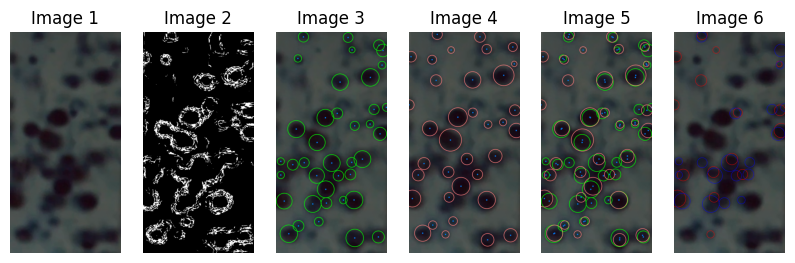

In [11]:
import os
import cv2

folder=r"C:\Users\Asus\Desktop\final videos coluna\final\c1_1"
csv_files = [file for file in os.listdir(folder) if file.endswith('.csv')]
# Choose a random CSV file from the list
random_csv_file ="left_frame_13.csv"
print('nome do ficheiro', random_csv_file)
# Find the corresponding image file with the same name as the random CSV file (but ending with '.jpg')

image_file_path = 'left_frame_13.jpg'


file_right = open (random_csv_file)
csvreader = csv.reader(file_right)
rows = []
for row in csvreader:
    rows.append(row)
file_right.close()



im_right = cv2.imread(image_file_path)
desired_width = 1000
desired_height = 2000
# Resize the image
im_right = cv2.resize(im_right, (desired_width, desired_height))
# Read the input image
low_threshold = 70
high_threshold = 110
# Apply Canny edge detection with the specified thresholds
result = apply_canny_edge_detection(im_right, low_threshold, high_threshold)
result=t.apply_morphology_operations(result)

Tol=50
Tol_int=10
diam_min=10
diam_max=100


resultado=detect_circles_final(im_right,result,tolerancia=10,tolerancia_int=1,minR=35,maxR=150)
lista_2=resultado[0]


imagem_final_2=d.draw_green_circles(lista_2,im_right)

imagem_final_2_5=d.draw_blue_circles(rows,im_right)

imagem_final_3=d.draw_blue_circles(rows,imagem_final_2)

Valor=detect_circles_score(im_right,rows,lista_2,tolerance=0.5,radius_margin=0.5)
print('recall:',Valor[0])
print('precision:',Valor[2])



imagens=[im_right,result,imagem_final_2,imagem_final_2_5,imagem_final_3,Valor[1]]

display_images(imagens)

